In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
import data_handler

/storagenfs/m.melerocavallo/HLTKeyPointAnalysis/venv2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device(2)

# Data Management

In [4]:
df_train, df_val, df_test = data_handler.load_full_dataset('../dataset/', get_train=True, get_dev=True, get_test=True)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24093 entries, 0 to 3457
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   argument   24093 non-null  object
 1   key_point  24093 non-null  object
 2   topic      24093 non-null  object
 3   stance     24093 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 941.1+ KB


In [6]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426 entries, 0 to 3425
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   argument   3426 non-null   object
 1   key_point  3426 non-null   object
 2   topic      3426 non-null   object
 3   stance     3426 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 107.2+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   argument  18398 non-null  object
 1   topic     18398 non-null  object
 2   stance    18398 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 431.3+ KB


In [8]:
print(f"Number of unique topics present in Training set: {len(df_train['topic'].unique())}")
print(f"Number of unique topics present in Validation set: {len(df_val['topic'].unique())}")
print(f"Number of unique topics present in Test set: {len(df_test['topic'].unique())}")

Number of unique topics present in Training set: 28
Number of unique topics present in Validation set: 3
Number of unique topics present in Test set: 43


In [9]:
#Check if there are some shared topics
print(f"Overlap of topics between Training and Validation: {len(np.intersect1d(df_train['topic'].unique(), df_val['topic'].unique()))}")
print(f"Overlap of topics between Training and Test: {len(np.intersect1d(df_train['topic'].unique(), df_test['topic'].unique()))}")
print(f"Overlap of topics between Test and Validation: {len(np.intersect1d(df_val['topic'].unique(), df_test['topic'].unique()))}")

Overlap of topics between Training and Validation: 0
Overlap of topics between Training and Test: 0
Overlap of topics between Test and Validation: 0


In [10]:
# Concatenate topics and keypoints, as stated in the paper
df_train = data_handler.concatenate_topics(df_train, input_col='argument', output_col='argument')
df_val = data_handler.concatenate_topics(df_val, input_col='argument', output_col='argument')
df_test = data_handler.concatenate_topics(df_test, input_col='argument', output_col='argument')

In [11]:
n_words = pd.DataFrame()
n_words['words_per_arg_train'] = df_train['argument'].str.split().apply(len)
n_words['words_per_arg_val'] = df_val['argument'].str.split().apply(len)
n_words['words_per_arg_test'] = df_test['argument'].str.split().apply(len)

<AxesSubplot: >

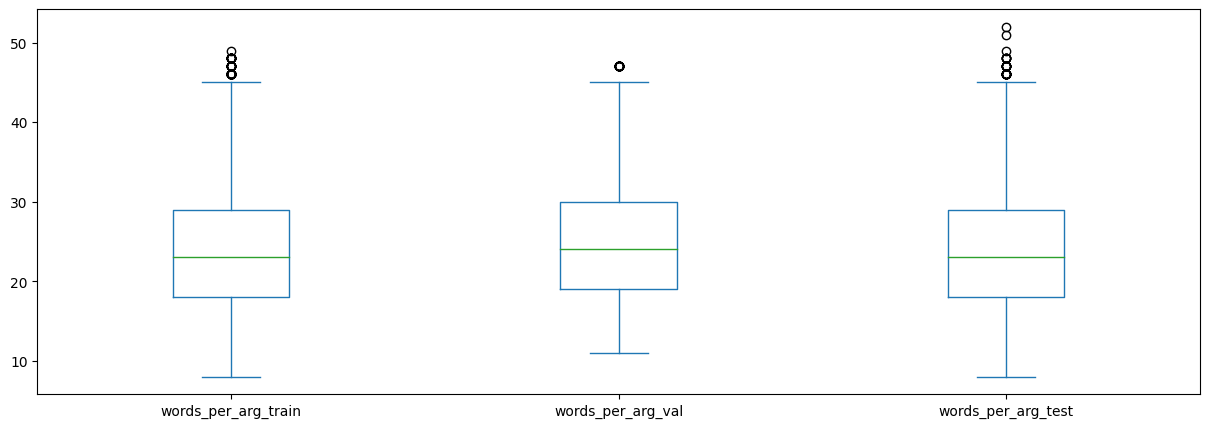

In [12]:
n_words.plot.box(figsize=(15, 5))

In [13]:
print(f"Max number of words for Training args: {n_words['words_per_arg_train'].max()}")
print(f"Max number of words for Validation args: {n_words['words_per_arg_val'].max()}")
print(f"Max number of words for Test args: {n_words['words_per_arg_test'].max()}\n")

Max number of words for Training args: 49
Max number of words for Validation args: 47.0
Max number of words for Test args: 52.0



In [14]:
def tokenization_target(sentences, tokenizer, max_length=512):
     # Tokenize all of the sentences and map the tokens to thier word IDs.
        input_ids = []
        attention_masks = []

      # For every sentence...
        with tokenizer.as_target_tokenizer():
            for sent in sentences:
              # `encode_plus` will:
              #   (1) Tokenize the sentence.
              #   (2) Prepend the `[CLS]` token to the start.
              #   (3) Append the `[SEP]` token to the end.
              #   (4) Map tokens to their IDs.
              #   (5) Pad or truncate the sentence to `max_length`
              #   (6) Create attention masks for [PAD] tokens.
                encoding = tokenizer.encode_plus(
                                  sent,                      # Sentence to encode.
                                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                  max_length = max_length,   # Pad & truncate all sentences.
                                  pad_to_max_length = True,
                                  return_attention_mask = True,   # Construct attn. masks.
                                  return_tensors = 'pt',     # Return pytorch tensors.
                                  truncation=True
                            )

              # Add the encoded sentence to the list.    
                input_ids.append(encoding['input_ids'])

              # And its attention mask (simply differentiates padding from non-padding).
                attention_masks.append(encoding['attention_mask'])

      # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        return input_ids, attention_masks

In [15]:
def tokenize_df_gen(df, tokenizer, max_length=512):
    input_id_args, attention_masks_args = tokenization(df['argument'], tokenizer, max_length=max_length)
    input_id_kps, attention_masks_kps = tokenization_target(df['key_point'], tokenizer, max_length=max_length)

    '''tokenized = [ { 'id': i,
        'argument':{
            'input_ids': input_id_args[i],
            'attention_masks' : attention_masks_args[i]
            }, 
            'kp':{
                'input_ids': input_id_kps[i],
                'attention_masks' : attention_masks_kps[i]
            }} for i in range(len(input_id_args)) ]'''
    
    tokenized_args = [{
            'input_ids': input_id_args[i],
            'attention_mask' : attention_masks_args[i]
            } for i in range(len(input_id_args)) 
    ]
    
    tokenized_kps = [{
            'input_ids': input_id_kps[i],
            'attention_mask' : attention_masks_kps[i]
            } for i in range(len(input_id_kps)) 
    ]

    return tokenized_args, tokenized_kps

In [16]:
from data_handler import tokenization
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('google/pegasus-xsum')
tokenized_tr = tokenize_df_gen(df_train, tokenizer, max_length=60)

/storagenfs/m.melerocavallo/HLTKeyPointAnalysis/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/storagenfs/m.melerocavallo/HLTKeyPointAnalysis/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  war

In [17]:
# Tokenizing without padding to check token lengths
args_len = [len(tokenizer.encode(s)) for s in df_train['argument']]
kps_len = [len(tokenizer.encode(s)) for s in df_train['key_point']]

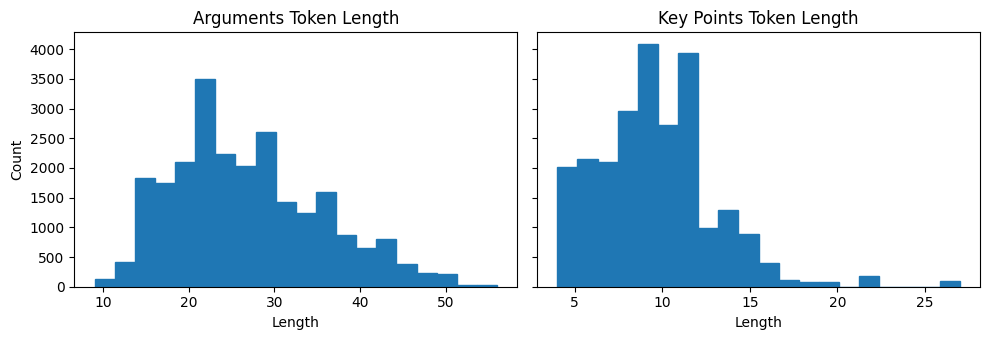

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(args_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Arguments Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(kps_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Key Points Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [162]:
x = -0.3
real_min = -1
real_max = 1
expec_min = 0
expec_min = 1
m = ((x - real_min)/(real_max-(real_min))) * (expec_max-expec_min) + expec_min
m

0.35

In [19]:
from transformers import BertModel, AutoModel, Trainer, TrainingArguments
from transformers import DataCollatorForSeq2Seq
from torch.utils.data import DataLoader

In [20]:
model = AutoModel.from_pretrained("google/pegasus-xsum",
                                          num_labels = 2)

Some weights of the model checkpoint at google/pegasus-xsum were not used when initializing PegasusModel: ['final_logits_bias']
- This IS expected if you are initializing PegasusModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PegasusModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PegasusModel were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EXAMPLE WITH DATASET FROM BOOK

In [ ]:
from datasets import load_dataset
dataset_samsum_pt = load_dataset("samsum")

In [31]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [59]:
sentences = [dataset_samsum_pt['train'][x]['dialogue'] for x in range(0,len(dataset_samsum_pt['train']))]
sentences[0]

"Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)"

In [61]:
input_ids_samsum, attention_mask_samsum = tokenization_target(sentences, tokenizer, max_length=512)

In [86]:
tokenized = [ { 'input_ids': input_ids_samsum[i],
            'attention_mask' : attention_mask_samsum[i]
            } for i in range(len(input_ids_samsum)) ]

In [ ]:
seq2seq_data_collator(tokenized)

In [87]:
train_loader_samsum = DataLoader(tokenized, shuffle=True, batch_size=16, collate_fn=seq2seq_data_collator, pin_memory=True)

In [88]:
for i, e in enumerate(train_loader_samsum):
    print(e)
    break

{'input_ids': tensor([[ 7819,   151,   463,  ...,     0,     0,     0],
        [19622,  6867,   151,  ...,     0,     0,     0],
        [ 9479,   151,   110,  ...,     0,     0,     0],
        ...,
        [ 3104,   151,   842,  ...,     0,     0,     0],
        [ 2180,   151, 10532,  ...,     0,     0,     0],
        [33716,   151,  4366,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


EXAMPLE WITH OUR DATASET

In [21]:
tokenized_tr_args, tokenized_tr_kps = tokenize_df_gen(df_train, tokenizer, max_length=512)

/storagenfs/m.melerocavallo/HLTKeyPointAnalysis/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/storagenfs/m.melerocavallo/HLTKeyPointAnalysis/venv2/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  war

In [32]:
# Teacher forcing args or kps?
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
train_loader = DataLoader(tokenized_tr_args, shuffle=True, batch_size=16, collate_fn=seq2seq_data_collator, pin_memory=True)

In [ ]:
for i, e in enumerate(train_loader):
    print(i)
    print(e)
    break

In [ ]:
epochs = 1

model.train()
    
# loss_function.to(device)
results = {}

'''results = {'loss': torch.zeros([epochs,1]),
          'predicted': torch.zeros([epochs,len(train_loader.dataset)]),
          'labels': torch.zeros([epochs,len(train_loader.dataset)])
          }

results = {k:v.to(device) for k,v in results.items()}'''

for epoch in range(0, epochs):

    '''epoch_results = {'loss': torch.zeros([len(train_loader),1]),
          'predicted': torch.zeros([len(train_loader.dataset)]),
          'labels': torch.zeros([len(train_loader.dataset)])
    }

    epoch_results = {k:v.to(device) for k,v in epoch_results.items()}'''

    for batch_idx, (encodings) in enumerate(train_loader):

        # Extract arguments, key_points and labels all from the same batch
        '''args = {k:v.to(device) for k,v in encodings['argument'].items()}

        kps = {k:v.to(device) for k,v in encodings['kp'].items()}'''

        
        #labels = encodings['label']
        #labels = labels.to(device)

        optimizer.zero_grad()
        outp = model(encodings)

        loss = loss_function(outp.float(), labels.float())
        loss.backward()

        # Compute start and end index of the slice to assign
        '''start_idx = batch_idx*train_loader.batch_size;
        if batch_idx < (len(train_loader)-1):
            end_idx = (batch_idx+1)*(len(outp))
        else:
            end_idx = len(train_loader.dataset)

        epoch_results['loss'][batch_idx] = loss'''

        # Saves predictions and targets in respective position
        # of the epoch_results arrays, this has been done because the
        # data shuffles at each iteration
        '''j = 0
        for i in range(0, len(encodings['id'])):
            index = encodings['id'][i]
            epoch_results['predicted'][index] = outp[j]
            epoch_results['labels'][index] = labels[j]
            j+=1'''

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        if verbose:
            if batch_idx % 10 == 0:
                print(f'Train Epoch:', epoch, 'batch:',
                    batch_idx, 'loss:',
                    loss.mean())

TEST/EVALUATION

In [ ]:
#loss_function.to(device)

from main_task2 import PegasusModel
from datasets import load_metric
model_p = PegasusModel() 


rouge_metric = load_metric("rouge")

'''results = {'labels': torch.zeros([len(train_loader),1]),
           'predicted':torch.zeros([len(train_loader),1]),
           'loss':torch.zeros([len(train_loader),1])
          }'''

#results = {k:v.to(device) for k,v in results.items()}


with torch.no_grad():
    for batch_idx, (encodings) in enumerate(train_loader):

        # Extract arguments, key_points and labels all from the same batch
        '''args = {k:v.to(device) for k,v in encodings['argument'].items()}

        kps = {k:v.to(device) for k,v in encodings['kp'].items()}'''

        '''labels = encodings['label']
        labels = labels.to(device)'''

        outp = model_p.generate(encodings)

        #loss = loss_function(outp.float(), labels.float())

        results['summary'][batch_idx] = outp
        results['predicted'][batch_idx] = outp
        #results['loss'][batch_idx] = loss

decoded = tokenizer.batch_decode(results['summary'], skip_special_tokens=True)
        
print(decoded)

metric.add_batch(predictions=decoded, references=target_batch)
score = metric.compute()

In [ ]:
dir(model_p.model)

In [27]:
training_args = TrainingArguments(
output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
per_device_train_batch_size=1, per_device_eval_batch_size=1,
weight_decay=0.01, logging_steps=10, push_to_hub=True,
evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
gradient_accumulation_steps=16)

In [ ]:
trainer = Trainer(model=model, args=training_args,
tokenizer=tokenizer, data_collator=seq2seq_data_collator,
train_dataset=dataset_samsum_pt["train"],
eval_dataset=dataset_samsum_pt["validation"])